In [1]:
import pandas as pd
import numpy as np
import os

RANDOM_STATE = 404

In [2]:
df = pd.read_csv('data/HAD.csv')
df.head()

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,ONSET_TO_ADMISSION,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING,MRS_90,MRS_90_DICHO
0,70,0,0,3,0,-1,1,0,0,0,...,64,0,96,0,180,0,-1,1,0,0
1,55,0,0,6,0,142,0,3,0,0,...,38,0,104,0,165,0,-1,1,4,1
2,73,0,0,3,0,170,0,0,0,1,...,-1,1,-1,1,-1,1,-1,1,2,0
3,81,0,0,10,0,-1,1,0,0,0,...,69,0,90,0,115,0,-1,1,3,1
4,81,0,1,11,0,-1,1,0,0,0,...,98,0,110,0,120,0,-1,1,0,0


In [3]:
target_feature = 'MRS_90'
y = df.filter([target_feature])
# y.to_csv('data/HAD_target.csv', index=False)

#### Because of the warning given while imputing missing values, 'SERUM_GLUCOSE' and 'VALV_HEART' columns are removed due to not having any other entry than '-1' value

In [4]:
df = df.drop(columns={'SERUM_GLUCOSE', 'SERUM_GLUCOSE_MISSING', 'VALV_HEART', 'MRS_90', 'MRS_90_DICHO'}, axis=1)

In [5]:
from sklearn.preprocessing import StandardScaler

# Replace all -1 values with NaN to avoid normalization on missing values
df.replace(-1, np.nan, inplace=True)

# Initialize the scaler
scaler = StandardScaler()

# Columns to scale
columns_to_scale = [col for col in df.columns if '_MISSING' not in col]

# Fit and transform the selected columns
scaled_data = scaler.fit_transform(df[columns_to_scale])

# Convert the scaled data back to DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Retrieve the unscaled columns
unscaled_columns = [col for col in df.columns if col not in columns_to_scale]

# Concatenate scaled and unscaled columns
df = pd.concat([df_scaled, df[unscaled_columns]], axis=1)

# Reverting the NaN values
# df.replace(np.nan, -1, inplace=True)

df

,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,AGE_MISSING,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS_MISSING,ASPECTS_MISSING,CTA_CS_MISSING,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN_MISSING
0,0.000972,-0.908801,-0.870588,NaN,-0.641768,-0.370094,0.674720,0.991543,-0.660934,1.867007,...,0,0,1,0,0,1,0,0,0,1
1,-1.053091,-0.908801,-0.513781,-0.323477,1.622132,-0.370094,0.674720,0.991543,-0.660934,-0.535617,...,0,0,0,0,0,1,0,0,0,1
2,0.211784,-0.908801,-0.870588,0.767434,-0.641768,2.702015,0.674720,0.991543,-0.660934,-0.535617,...,0,0,0,0,1,1,1,1,1,1
3,0.773951,-0.908801,-0.038039,NaN,-0.641768,-0.370094,0.674720,-1.008529,1.513010,-0.535617,...,0,0,1,0,1,1,0,0,0,1
4,0.773951,1.100351,0.080897,NaN,-0.641768,-0.370094,0.674720,0.991543,-0.660934,-0.535617,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.071243,-0.908801,-0.870588,NaN,-0.641768,-0.370094,-1.482097,-1.008529,-0.660934,-0.535617,...,0,0,1,0,0,1,0,0,0,1
940,-0.490924,-0.908801,-0.870588,-0.323477,1.622132,-0.370094,0.674720,-1.008529,-0.660934,-0.535617,...,0,0,0,0,0,1,1,0,0,1
941,-0.631466,1.100351,-1.227395,-1.804000,-0.641768,-0.370094,0.674720,-1.008529,-0.660934,-0.535617,...,0,0,0,0,1,1,1,1,1,1
942,0.703680,1.100351,0.199833,NaN,-0.641768,-0.370094,0.674720,0.991543,-0.660934,-0.535617,...,0,0,1,0,0,0,0,0,1,0


## Generating missing data based on sklearn imputers

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer_df = df.copy()  # Creating a copy of the original DataFrame for imputation

# Initialize IterativeImputer with median strategy for missing values
imp = IterativeImputer(missing_values=np.NaN, initial_strategy='median', random_state=RANDOM_STATE)

# Iterate through columns in the DataFrame
for col in imputer_df.columns:
    # Skip columns ending with '_MISSING'
    if col.endswith('_MISSING'):
        continue
    # Check if there is a corresponding missing flag column
    elif col + "_MISSING" in df.columns:
        # Check if there are missing values to impute
        if (imputer_df[col + "_MISSING"] == 1).any() and (pd.isna(imputer_df[col])).any():
            # Fit imputer on the column and transform the values
            imp.fit(imputer_df[[col]])
            imputer_df[col] = imp.transform(imputer_df[[col]]).ravel()
    else:
        # Check if there are missing values to impute
        if (pd.isna(imputer_df[col])).any():
            # Fit imputer on the column and transform the values
            imp.fit(imputer_df[[col]])
            imputer_df[col] = imp.transform(imputer_df[[col]]).ravel()

# Remove columns related to missingness flags
imputer_df = imputer_df[imputer_df.columns.drop(list(imputer_df.filter(regex='MISSING')))]

# Save the imputed DataFrame to a CSV file
imputer_df.to_csv('data/HAD_after_imputer.csv', index=False)

imputer_df

,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,0.000972,-0.908801,-0.870588,-0.089710,-0.641768,-0.370094,0.674720,0.991543,-0.660934,1.867007,...,1.896935,-0.705224,-0.153741,-0.241393,-0.201657,-0.600262,-0.463051,-0.420715,0.010290,-0.370177
1,-1.053091,-0.908801,-0.513781,-0.323477,1.622132,-0.370094,0.674720,0.991543,-0.660934,-0.535617,...,-0.527166,-0.705224,-0.153741,-0.241393,-0.201657,-0.600262,-0.612093,-0.376619,-0.188548,-0.370177
2,0.211784,-0.908801,-0.870588,0.767434,-0.641768,2.702015,0.674720,0.991543,-0.660934,-0.535617,...,-0.527166,-0.705224,-0.153741,-0.241393,-0.201657,-0.600262,-0.314010,-0.310475,-0.122269,-0.370177
3,0.773951,-0.908801,-0.038039,-0.089710,-0.641768,-0.370094,0.674720,-1.008529,1.513010,-0.535617,...,-0.527166,-0.705224,-0.153741,4.142619,-0.201657,-0.600262,-0.434390,-0.453787,-0.851341,-0.370177
4,0.773951,1.100351,0.080897,-0.089710,-0.641768,-0.370094,0.674720,0.991543,-0.660934,-0.535617,...,-0.527166,-0.705224,-0.153741,-0.241393,-0.201657,-0.600262,-0.268151,-0.343547,-0.785062,-0.370177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.071243,-0.908801,-0.870588,-0.089710,-0.641768,-0.370094,-1.482097,-1.008529,-0.660934,-0.535617,...,-0.527166,-0.705224,-0.153741,-0.241393,4.958922,-0.600262,0.196170,0.113951,0.659828,-0.370177
940,-0.490924,-0.908801,-0.870588,-0.323477,1.622132,-0.370094,0.674720,-1.008529,-0.660934,-0.535617,...,-0.527166,-0.705224,-0.153741,-0.241393,-0.201657,-0.600262,-0.314010,-0.167162,-0.188548,-0.370177
941,-0.631466,1.100351,-1.227395,-1.804000,-0.641768,-0.370094,0.674720,-1.008529,-0.660934,-0.535617,...,-0.527166,-0.705224,-0.153741,-0.241393,-0.201657,-0.600262,-0.314010,-0.310475,-0.122269,-0.370177
942,0.703680,1.100351,0.199833,-0.089710,-0.641768,-0.370094,0.674720,0.991543,-0.660934,-0.535617,...,-0.527166,1.417990,-0.153741,-0.241393,-0.201657,-0.600262,1.921610,1.916382,-0.122269,1.165557


### Using BIC to get the optimal number of components for GMM

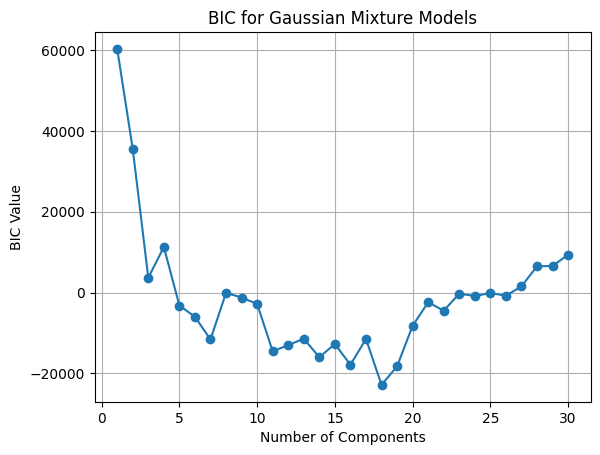

In [7]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def compute_bic(X, n_components_range):
    """
    Computes the Bayesian Information Criterion (BIC) for Gaussian Mixture Models with different numbers of components.
    
    Parameters:
        X (array-like): Input data.
        n_components_range (range): Range of number of components to evaluate.
        
    Returns:
        list: BIC values for each number of components.
    """
    bic = []  # List to store BIC values
    for n_components in n_components_range:
        # Create Gaussian Mixture Model with specified number of components
        gmm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
        gmm.fit(X)
        bic.append(gmm.bic(X))  # Calculate BIC and add to list
    return bic  # Return list of BIC values

n_components_range = range(1, 31)  # Range of number of components to evaluate

bic_values = compute_bic(imputer_df, n_components_range)  # Compute BIC values

optimal_n_components = n_components_range[np.argmin(bic_values)]  # Determine optimal number of components

# Plotting BIC values
plt.plot(n_components_range, bic_values, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Value')
plt.title('BIC for Gaussian Mixture Models')
plt.grid(True)
plt.show()


### Gaussian Mixture Model fitting

In [8]:
# Create Gaussian Mixture Model with optimal number of components
gmm = GaussianMixture(n_components=optimal_n_components, random_state=RANDOM_STATE)

# Fit the Gaussian Mixture Model to the imputed DataFrame
gmm.fit(imputer_df)

GaussianMixture(n_components=18, random_state=404)

### Can set all the values of a specific feature to -1 for the purpose of displaying it's distribution on the heatmap below

In [9]:
# Saving the values of a feature to mark them in the heatmap, e.g. CTA_CS
heatmap_feature = 'SYS_BLOOD_PRESSURE'
heatmap_feature_original_values = pd.Series(df[heatmap_feature].copy().values, index=df.index)

# Get maximum and minimum values from the column
heatmap_feature_max_value = df[heatmap_feature].max()
heatmap_feature_min_value = df[heatmap_feature].min()

df[heatmap_feature] = np.NaN
# Check if the column exists
if heatmap_feature + '_MISSING' in df.columns:
    df[heatmap_feature + '_MISSING'] = 1

### Generating samples of missing values using conditional GMM

In [10]:
from ConditionalGMM.condGMM import CondGMM
import json

def gmm_generate_samples(n_datapoints=2, n_samples=1000, plot_histograms=False, print_index=False):
    """
    Generate samples using Conditional Gaussian Mixture Model for imputing missing data.

    Args:
        n_datapoints (int/str): Number of data points to consider
        n_samples (int): Number of samples to generate
        plot_histograms (bool): Whether to plot histograms of sampled data
        print_index (bool): Whether to print the index of the current data point
    Returns:
        pd.DataFrame: DataFrame with imputed missing data
    """
    if n_datapoints > df.shape[0]:
        n_datapoints = df.shape[0]

    # Create a copy of the DataFrame for data manipulation
    temp_df = df.head(n_datapoints).copy().astype(object)
    # Remove missing flag columns
    temp_df = temp_df[temp_df.columns.drop(list(temp_df.filter(regex='MISSING')))]
        
    for index, row in df.head(n_datapoints).iterrows():
        # Get indices and values of unknown and known features
        unknown_features_indexes, known_features_indexes, known_features_values = get_feature_indices_and_values(temp_df, index, row)
        
        # If all features are known, continue
        if len(unknown_features_indexes) == 0:
            continue
        
        # Initialize CondGMM
        cGMM = CondGMM(gmm.weights_, gmm.means_, gmm.covariances_, known_features_indexes)
        
        # Generate samples using Conditional GMM
        sampled_data = cGMM.rvs(known_features_values, size=n_samples, random_state=RANDOM_STATE)
        
        # Update unknown features with sampled data
        for feature_index in range(len(unknown_features_indexes)):
            temp_df.iloc[index, unknown_features_indexes[feature_index]] = json.dumps([sampled_data[sample_index][feature_index] for sample_index in range(n_samples)])

        # Plot histograms if specified
        if plot_histograms:
            plot_histogram(temp_df, unknown_features_indexes, index, sampled_data)
        
        # Print index if specified, for debugging purposes
        if print_index:
            print(index)
        
    return temp_df
        
def get_feature_indices_and_values(temp_df, index, row):    
    unknown_features_indexes = []  # Initialize list to store indices of unknown features
    
    # Iterate through columns in the DataFrame
    for col in df.columns:
        # Skip columns ending with '_MISSING'
        if col.endswith('_MISSING'):
            continue
        # Check if there is a corresponding missing flag column
        elif col + "_MISSING" in df.columns:
            # Identify unknown features where missing flag is 1 and value is NaN
            if row[col + "_MISSING"] == 1 and (pd.isna(row[col])):
                unknown_features_indexes.append(temp_df.columns.get_loc(col))  # Add index of feature
        else:
            # Identify unknown features where value is NaN
            if (pd.isna(row[col])):
                unknown_features_indexes.append(temp_df.columns.get_loc(col))  # Add index of feature
        
    # Find indices of known features
    known_features_indexes = list(set(range(temp_df.shape[1])) - set(unknown_features_indexes))
    
    # Extract values of known features for the given row
    known_features_values = temp_df.iloc[index, known_features_indexes]
    
    return unknown_features_indexes, known_features_indexes, known_features_values  # Return indices and values

def plot_histogram(temp_df, unknown_features_indexes, index, sampled_data, n_bins=20):
    # Create subplots based on the number of unknown features
    fig, axs = plt.subplots(sampled_data.shape[1], 1, figsize=(8, len(unknown_features_indexes) * 4))

    # Plot histograms for each feature
    plot_features(temp_df, sampled_data, axs, unknown_features_indexes, index, n_bins)

    # Add title and labels to the figure
    fig.suptitle(f'Histograms for index {index}', fontsize=20)  # Title with the index
    fig.text(0.5, 0.04, 'Value', ha='center', fontsize=14)  # X-axis label
    fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)  # Y-axis label
    plt.show()  # Show the figure

    
def plot_features(temp_df, sampled_data, axs, unknown_features_indexes, index, n_bins):
    # Ensure axs is a list for consistency in cases when only one feature is plotted
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    for i in range(sampled_data.shape[1]):
        expected_value = imputer_df.iloc[index, unknown_features_indexes[i]]
        
        # Plot histogram for the feature
        axs[i].hist(sampled_data[:, i], bins=n_bins, alpha=0.5, label='sampled data')
        axs[i].hist(imputer_df[imputer_df.columns[unknown_features_indexes[i]]], bins=n_bins, alpha=0.2, label='marginal data')
        axs[i].set_title(f'{temp_df.columns[unknown_features_indexes[i]]}')
        
        # Add expected value as text on the histogram
        axs[i].text(0.95, 0.95, f'Expected value: {expected_value}', ha='right', va='top', transform=axs[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
        
        axs[i].legend(loc='upper left')

In [11]:
%load_ext autoreload
%autoreload 2

n_datapoints = df.shape[0]
number_of_samples = 10
cgmm_df = gmm_generate_samples(n_datapoints=n_datapoints, n_samples=number_of_samples)
cgmm_df.head()

,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,0.000972,-0.908801,-0.870588,"[-0.4070899783383677, -0.48331924881187316, -0...",-0.641768,-0.370094,0.67472,0.991543,-0.660934,1.867007,...,1.896935,-0.705224,-0.153741,-0.241393,-0.201657,"[-0.5794433357346913, -0.4979350274792042, -1....",-0.463051,-0.420715,0.01029,"[0.07987473058743444, 0.00641914797301768, 0.0..."
1,-1.053091,-0.908801,-0.513781,"[-0.36121210938766046, 0.5017826995942753, -0....",1.622132,-0.370094,0.67472,0.991543,-0.660934,-0.535617,...,"[-0.5267718383458794, -0.5269844698227595, -0....","[-1.251352730225954, 0.802447606985511, -0.518...","[-0.1536959629116783, -0.1536299586705271, -0....","[-0.24044372079069387, -0.2406444035300814, -0...","[-0.20328407415330912, -0.2019445548409912, -0...","[-0.5997544972934965, -0.5998986276698002, -0....",-0.612093,-0.376619,-0.188548,"[-0.3685108942166974, -0.37118293475330294, -0..."
2,0.211784,-0.908801,-0.870588,"[1.9543916626310072, 0.5240949352931826, 1.359...",-0.641768,2.702015,0.67472,0.991543,-0.660934,-0.535617,...,"[-0.8065263354118475, -1.0689664443526286, -1....","[-0.7062940953054488, -0.7057107100475588, -0....","[-0.15314770338007658, -0.1537991733324808, -0...","[-0.24182294867991333, -0.24118775699921047, -...","[-0.2000386485817795, -0.20134898176223825, -0...","[-0.5999220966946743, -0.6009675961537582, -0....","[-0.2448809093783057, -0.3933512327131784, -0....","[-0.18979318083757446, -0.43116250372877357, -...","[-0.13080562388188044, -0.560653413233057, -0....","[-0.3705273627203377, -0.37045368998618305, -0..."
3,0.773951,-0.908801,-0.038039,"[0.2266527299282471, 0.058557055262237076, -0....",-0.641768,-0.370094,0.67472,-1.008529,1.51301,-0.535617,...,-0.527166,-0.705224,-0.153741,4.142619,-0.201657,"[-0.4863683480611706, -0.6728259847662276, -0....",-0.43439,-0.453787,-0.851341,"[-0.32720062478850026, -0.3730183698557628, -0..."
4,0.773951,1.100351,0.080897,"[-0.4362504550050069, 0.9056702873427536, 0.43...",-0.641768,-0.370094,0.67472,0.991543,-0.660934,-0.535617,...,"[-0.6314364650898205, -0.4189188594657737, -0....","[-0.7062906800919727, -0.7052539942763713, -0....","[0.43827462056640987, -1.3039680419011663, 0.1...","[-0.240357201651798, -0.24107205184221012, -0....","[-0.19999092501878388, -0.2026629655553894, -0...","[-0.6010957766290494, -0.6006123370378961, -0....",-0.268151,-0.343547,-0.785062,"[-0.3692272147550144, -0.36942789749440197, -0..."


## Calculate MSE for generated values

In [12]:
from sklearn.metrics import mean_squared_error

# Create output file
output_file_path = os.path.join("results", "with_missingness.txt")
with open(output_file_path, "a") as f:
    f.write(f"Results for {number_of_samples} samples:\n")

# Initialize dictionary to store MSE and NMSE values for each feature
feature_mse = {}

for index, row in cgmm_df.iterrows():
    # Get the indices and values of unknown features
    unknown_features_indexes = [col_index for col_index, col in enumerate(row) if isinstance(col, str)]
    
    # If all features are known, continue
    if len(unknown_features_indexes) == 0:
        continue
    
    # Compare values of generated samples with imputed values
    for feature_index in range(len(unknown_features_indexes)):
        imputed_value = imputer_df.iloc[index, unknown_features_indexes[feature_index]]
        sampled_value = json.loads(row.iloc[unknown_features_indexes].values[feature_index])
        
        for sample in sampled_value:
            if not pd.isna(sample):
                # Calculate mean squared error
                mse = mean_squared_error(imputed_value.flatten(), np.array(sample).flatten())
                
                # Save each mse and nmse to its corresponding feature in feature_mse and feature_nmse
                if unknown_features_indexes[feature_index] not in feature_mse:
                    feature_mse[unknown_features_indexes[feature_index]] = []
                
                feature_mse[unknown_features_indexes[feature_index]].append(mse)
        
# Print the mean squared error and normalized mean squared error for each feature and save to file
with open(output_file_path, "a") as f:
    for feature_index, mse_list in feature_mse.items():
        mean_mse = np.mean(mse_list)
        f.write(f'Feature {cgmm_df.columns[feature_index]} MSE: {mean_mse}\n')
        print(f'Feature {cgmm_df.columns[feature_index]} MSE: {mean_mse}')
        
with open(output_file_path, "a") as f:
    f.write(f"\n\n")

Feature SYS_BLOOD_PRESSURE MSE: 0.4976548533187002
Feature CTA_CS MSE: 0.025887962374531084
Feature ONSET_TO_GROIN MSE: 0.051057391764871105
Feature OCCLUSION_M1 MSE: 0.2061843044861942
Feature OCCLUSION_M2 MSE: 0.053300220003404154
Feature OCCLUSION_ICA MSE: 0.16313473547062307
Feature OCCLUSION_ACA MSE: 0.28246401641410507
Feature OCCLUSION_PCA MSE: 0.00015410741536577634
Feature OCCLUSION_VB MSE: 0.00010769565305024088
Feature ASPECTS MSE: 0.145930836443704
Feature ONSET_TO_ADMISSION MSE: 0.07046298833860845
Feature ONSET_TO_IMAGING MSE: 0.07824529049613418
Feature ONSET_TO_TPA MSE: 0.02683307999214638
Feature NIHSS_BL MSE: 0.6504690963483135
Feature PREV_MRS MSE: 0.8303507935713074
Feature ORAL_ANTICOAGULANT MSE: 0.046046099058717586
Feature PREV_STROKE MSE: 0.7897387432849478
Feature AF MSE: 7.539998789215147e-07
Feature DM MSE: 0.22986882596010258
Feature IVT MSE: 0.38542710035063454
Feature HYPERTENSION MSE: 0.6864813484852398
Feature AGE MSE: 1.2065090970084231
Feature SMOKING 

## Generating heatmap which helps visualize how cGMM distributes data

In [13]:
# Save the original values of the heatmap feature
heatmap_feature_values = cgmm_df[heatmap_feature]
heatmap_feature_values

0      [-0.4070899783383677, -0.48331924881187316, -0...
1      [-0.36121210938766046, 0.5017826995942753, -0....
2      [1.9543916626310072, 0.5240949352931826, 1.359...
3      [0.2266527299282471, 0.058557055262237076, -0....
4      [-0.4362504550050069, 0.9056702873427536, 0.43...
                             ...                        
939    [-0.08815385586247478, -0.08776826462008287, -...
940    [0.5906386811430452, -0.19619192269489738, 0.0...
941    [0.36058947173798467, -0.4670694483197801, -0....
942    [0.23552263151238764, -0.6108746821967654, -0....
943    [-0.055130852059157597, -0.04567934123594325, ...
Name: SYS_BLOOD_PRESSURE, Length: 944, dtype: object

In [14]:
for i, entry in enumerate(heatmap_feature_values):
    if isinstance(entry, str):
        # Deserialize the string back into an array
        float_array = json.loads(entry)
        # Replace the string entry with the deserialized array
        heatmap_feature_values[i] = float_array

### Define the histogram bins for the heatmap

In [15]:
# Define bin edges and adjust number of bins
n_bins = 23
h_min = heatmap_feature_min_value
h_max = heatmap_feature_max_value
width = (h_max - h_min) / (n_bins-1)
bin_edges = np.arange(h_min - width/2, h_max +  width, width)

# Determine the number of samples based on the length of an entry with a list of values
list_length = None
for entry in heatmap_feature_values:
    if isinstance(entry, list):
        list_length = len(entry)
        break

histograms = []

for entry in heatmap_feature_values:
    if isinstance(entry, list):
        # Apply np.histogram with specified bin edges
        hist, _ = np.histogram(entry, bins=bin_edges)
        histograms.append(hist)
    else:
        # Single-value entry: Place it in the correct bin and set frequency to list_length
        hist = np.zeros(len(bin_edges) - 1)
        index = np.digitize([entry], bin_edges)[0] - 1
        if 0 <= index < len(hist):
            hist[index] = list_length
        histograms.append(hist)

# Reshape histograms to fit imshow format (histograms should be a 2D array)
histograms_2d = np.array(histograms)

# Determine figure height based on the number of datapoints
fig_height = max(6, n_datapoints * 0.2)
fig_width = min(max(10, bin_edges.shape[0] * 1), 32)

extent = [bin_edges[0], bin_edges[-1], 0, len(histograms)]

# Create heatmap
plt.figure(figsize=(fig_width, fig_height))
plt.imshow(histograms_2d, aspect='auto', cmap='Reds', extent=extent)
plt.colorbar()
plt.xticks(bin_edges, labels=np.round(bin_edges, 2), rotation=90)
plt.yticks(range(n_datapoints), range(n_datapoints))
plt.xlabel('Values')
plt.ylabel('Index')
plt.title(heatmap_feature + ' values heatmap generated by cGMM')

# Add markers for original values of a missing feature
original_values = heatmap_feature_original_values[heatmap_feature_original_values != -1] # Selecting only the non -1 values
indexes = heatmap_feature_original_values.index[heatmap_feature_original_values != -1] + 0.5 # Indexes corresponding to non -1 values
plt.scatter(original_values, indexes, color='red', marker='o', s=80, label='Original Values')
plt.scatter(imputer_df[heatmap_feature], imputer_df.index + 0.5, color='blue', marker='x', label='Imputer Values')

plt.grid(True)
plt.legend()
plt.savefig('images/heatmaps/' + heatmap_feature + '_heatmap.png')
plt.show()